In [1]:
import jax.random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
import optax
tfd = tfp.distributions
%load_ext autoreload

%cd /mnt/c/Users/Habush/PycharmProjects/bnn_bg

2023-12-20 17:36:25.721560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/c/Users/Habush/PycharmProjects/bnn_bg


In [66]:
%autoreload
from core.data_utils import *
seed = 0
num_tf, num_genes = 200, 10
tf_on, val_tf = 4, np.array([5, -5, 3, -3])
num_samples = 250
X, y, true_beta, true_beta_idx = generate_synthetic_data(key=random.PRNGKey(seed), num_tf=num_tf, 
                                                        tf_on=tf_on, num_samples=num_samples, num_genes=num_genes, 
                                                         binary=False, val_tf=val_tf)
print(X.shape)

tfs: (200, 250), genes: (200, 10, 250)
(250, 2200)


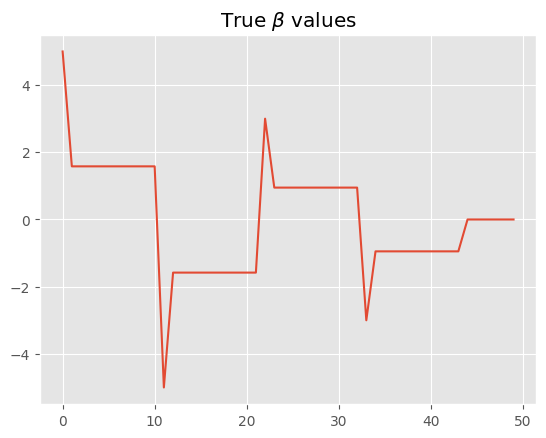

In [67]:
plt.plot(true_beta[:50])
plt.title(r'True $\beta$ values')
plt.show()

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

In [73]:
J = get_assoc_mat(num_tf=num_tf, num_genes=num_genes, corr=0.2)
J_zeros = np.zeros_like(J)

In [74]:
%autoreload
from core.spike_slab_ising import *
from s3.helper_functions import spike_slab_params
def mlp_fn(x, beta):
    return x @ beta

n, p = X_train.shape
params = spike_slab_params(n, p, type="linear")
tau0, tau1 = params["tau0"], params["tau1"]
a0, b0 = params["a0"], params["b0"]
q = params["q"]
eta, mu = 1.0, 100.0
print(params)
step_sizes = {"z": 0.1, "beta": 1e-3,  "sigma2": 1e-4}

samples_bg, accept_bg = spike_slab_inference(seed=seed, step_sizes=step_sizes, 
                               tau0=tau0, tau1=tau1, a0=0., b0=1., q=q,
                               J=J, eta=eta, mu=mu,
                               x=X_train, y=y_train, mlp_fn=mlp_fn, mh=False,
                               n_iters=2000, burn_in=1000, show_progress=True)

z_bg, beta_bg, sigma2_bg = samples_bg["z"], samples_bg["beta"], jax.nn.softplus(samples_bg["sigma2"])

samples_nbg, accept_probs_nbg = spike_slab_inference(seed=seed, step_sizes=step_sizes, 
                               tau0=tau0, tau1=tau1, a0=0., b0=1., q=q,
                               J=J_zeros, eta=eta, mu=mu, mh=False,
                               x=X_train, y=y_train, mlp_fn=mlp_fn,
                               n_iters=2000, burn_in=1000, show_progress=True)

z_nbg, beta_nbg, sigma2_nbg = samples_nbg["z"], samples_nbg["beta"], jax.nn.softplus(samples_nbg["sigma2"])

{'q': 0.003181818181818182, 'tau0': 0.07071067811865475, 'tau1': 1.0, 'a0': 1.0, 'b0': 1.0}


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.67it/s]


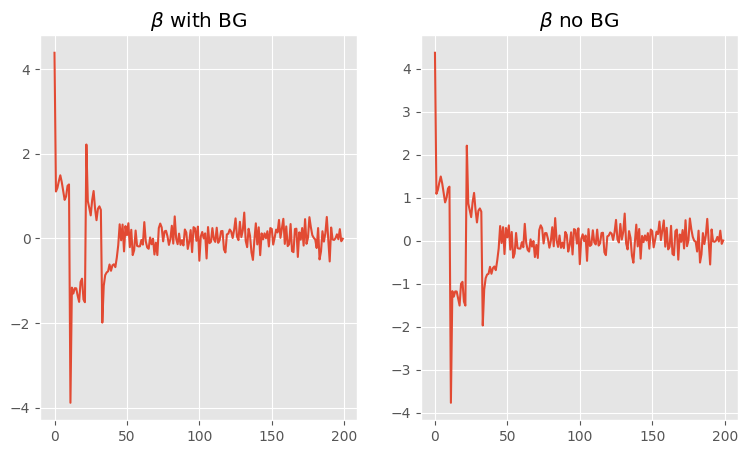

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax[0].plot(np.mean(beta_bg, axis=0)[:200])
ax[0].set_title(r"$\beta$ with BG")
ax[1].plot(np.mean(beta_nbg, axis=0)[:200])
ax[1].set_title(r"$\beta$ no BG")
plt.show()

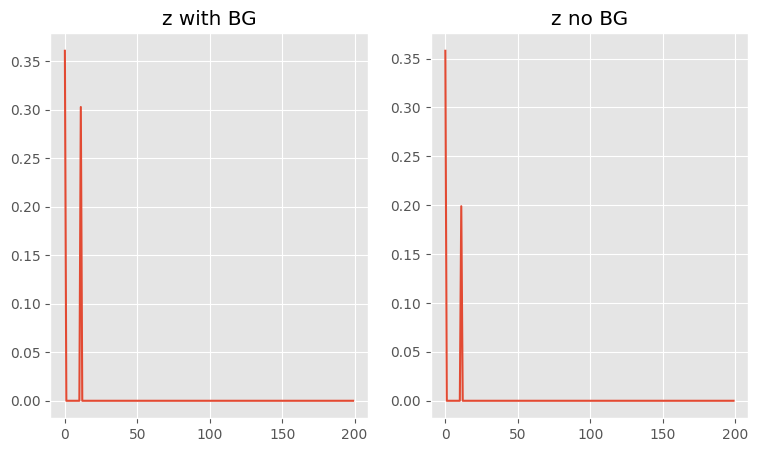

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax[0].plot(np.mean(z_bg, axis=0)[:200])
ax[0].set_title(r"z with BG")
ax[1].plot(np.mean(z_nbg, axis=0)[:200])
ax[1].set_title(r"z no BG")
plt.show()